#                                        Computer Vision Project                               

# Part A - Q1 A - Import and read ‘images.npy’.

In [18]:
import numpy as np

# Load the .npy file with allow_pickle=True
data = np.load('Images.npy', allow_pickle=True)

# Check the shape and type of the data
print(f"Shape of data: {data.shape}")
print(f"First entry: {data[0]}")

Shape of data: (393, 2)
First entry: [array([[[42, 37, 34],
         [56, 51, 48],
         [71, 66, 63],
         ...,
         [23, 33, 34],
         [26, 36, 37],
         [28, 38, 39]],

        [[40, 35, 32],
         [51, 46, 43],
         [64, 59, 56],
         ...,
         [27, 36, 35],
         [24, 33, 32],
         [26, 35, 34]],

        [[43, 38, 35],
         [51, 46, 43],
         [61, 56, 53],
         ...,
         [28, 30, 27],
         [33, 35, 32],
         [35, 37, 34]],

        ...,

        [[56, 47, 40],
         [57, 48, 41],
         [61, 52, 45],
         ...,
         [67, 48, 42],
         [55, 35, 28],
         [60, 40, 33]],

        [[53, 44, 37],
         [54, 45, 38],
         [57, 48, 41],
         ...,
         [59, 40, 34],
         [60, 40, 33],
         [54, 34, 27]],

        [[53, 44, 37],
         [54, 45, 38],
         [57, 48, 41],
         ...,
         [59, 40, 34],
         [70, 50, 43],
         [64, 44, 37]]], dtype=uint8)
 list([{'lab

# Part A - Q1 B - Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [19]:
import numpy as np
import cv2

# Target size for the images
target_size = (256, 256)

# Initialize lists for features (X) and labels (Y)
X = []
Y = []

# Process each entry in the data
for entry in data:
    # Extract the image and annotations
    image, annotations = entry

    # Determine the number of channels
    num_channels = image.shape[2] if len(image.shape) == 3 else 1

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)

    # Convert to a consistent number of channels (3 for RGB)
    if num_channels == 4:  # RGBA
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif num_channels == 1:  # Grayscale
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    # Append the resized image to X
    X.append(resized_image)

    # Extract and process annotations
    annotation_list = []
    for annotation in annotations:
        # Extract relevant info from each annotation
        label = annotation.get('label', 0)  
        points = annotation.get('points', 2)
        annotation_list.append(label)
        annotation_list.append(points)
    
    # Append the list of annotations to Y
    Y.append(annotation_list)

# Convert lists to numpy arrays (X) and list of lists (Y)
X = np.array(X)
# Y remains a list of lists to handle variable lengths

# Print the shapes of the resulting arrays
print(f"Features (X) shape: {X.shape}")
print(f"Labels (Y) length: {len(Y)}")

Features (X) shape: (393, 256, 256, 3)
Labels (Y) length: 393


# Part A - Q1 C - Split the data into train and test (70:30 ratio).

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training features (X_train) shape: {X_train.shape}")
print(f"Testing features (X_test) shape: {X_test.shape}")
print(f"Training labels (Y_train) length: {len(Y_train)}")
print(f"Testing labels (Y_test) length: {len(Y_test)}")


Training features (X_train) shape: (275, 256, 256, 3)
Testing features (X_test) shape: (118, 256, 256, 3)
Training labels (Y_train) length: 275
Testing labels (Y_test) length: 118


# Part A - Q1 D - Select random image from the train data and display original image and masked image.

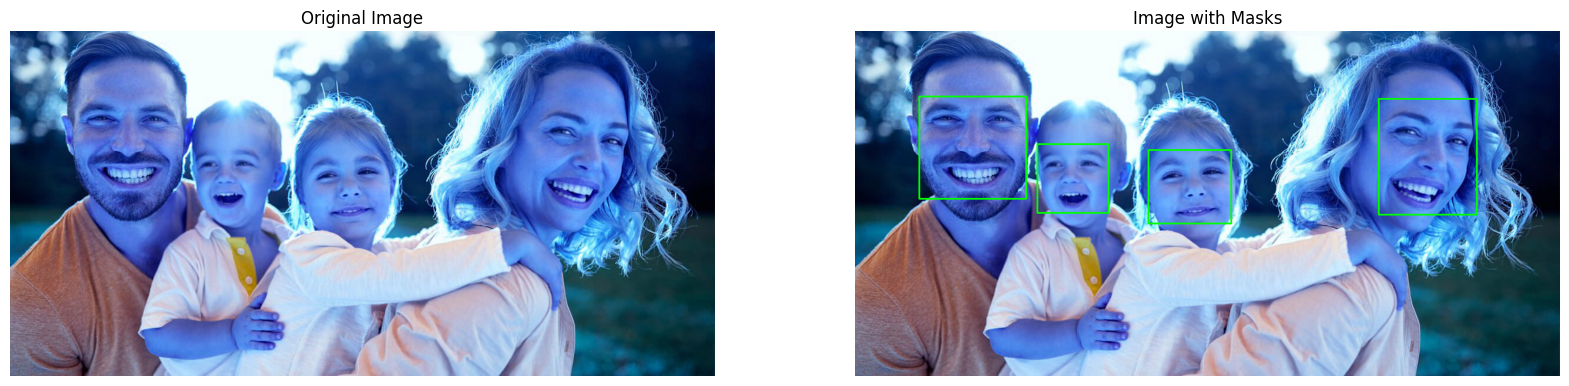

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Randomly select an image and its annotations
def select_random_image(X_train):
    index = random.randint(0, len(X_train) - 1)
    return data[index]

# Extract images and annotations
row_data, column_data = select_random_image(X_train)


# Convert normalized coordinates to pixel coordinates
def convert_points_to_pixel_coordinates(points, width, height):
    return [(int(p['x'] * width), int(p['y'] * height)) for p in points]

# Draw masks on images
def draw_masks_on_image(image, annotations):
    image_copy = image.copy()
    for annotation in annotations:
        points = convert_points_to_pixel_coordinates(annotation['points'], annotation['imageWidth'], annotation['imageHeight'])
        # Draw a rectangle around the face (assuming a bounding box here)
        if len(points) == 2:  # Simple case with two points
            p1, p2 = points
            top_left = (min(p1[0], p2[0]), min(p1[1], p2[1]))
            bottom_right = (max(p1[0], p2[0]), max(p1[1], p2[1]))
            cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)
        else:  # Draw a polygon if there are more points (assuming it's a more complex mask)
            pts = np.array(points, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(image_copy, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    return image_copy

# Draw masks on the image
image_with_masks = draw_masks_on_image(row_data, column_data)

# Convert images to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(row_data, cv2.COLOR_BGR2RGB)
image_with_masks_rgb = cv2.cvtColor(image_with_masks, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_with_masks_rgb)
plt.title('Image with Masks')
plt.axis('off')

plt.show()


# Part A - Q2 A - Design a face mask detection model.

In [24]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, DepthwiseConv2D, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Target size for the images and masks
target_size = (64, 64)  # Reduced size for faster processing on CPU

# Initialize lists for features (X) and labels (Y)
X = []
Y = []

def create_binary_mask(annotations, shape):
    """Create a binary mask from annotations containing multiple points."""
    mask = np.zeros(shape, dtype=np.float32)
    for annotation in annotations:
        if annotation['label'] == 'Face': 
            points = annotation['points']
            if len(points) > 1:
                # Convert points to pixel coordinates
                points = np.array([(int(point['x'] * shape[1]), int(point['y'] * shape[0])) for point in points])
                # Draw polygon on the mask
                cv2.fillPoly(mask, [points], color=1)
    return mask

# Process each entry in the data
for entry in data:
    # Extract the image and annotations
    image, annotations = entry

    # Determine the number of channels
    num_channels = image.shape[2] if len(image.shape) == 3 else 1

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)

    # Convert to a consistent number of channels (3 for RGB)
    if num_channels == 4:  # RGBA
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif num_channels == 1:  # Grayscale
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    # Append the resized image to X
    X.append(resized_image)

    # Create a binary mask from annotations
    binary_mask = create_binary_mask(annotations, (target_size[1], target_size[0]))
    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add channel dimension

    # Append the binary mask to Y
    Y.append(binary_mask)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize pixel values to the range [0, 1]
X = X.astype('float32') / 255.0
Y = Y.astype('float32')

# Define the split ratio
test_size = 0.3  # 30% for testing, 70% for training
random_state = 42  # For reproducibility

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

# Print the shapes of the resulting sets to verify
print(f"Training Features (X_train) shape: {X_train.shape}")  
print(f"Training Labels (Y_train) shape: {Y_train.shape}")   
print(f"Testing Features (X_test) shape: {X_test.shape}")      
print(f"Testing Labels (Y_test) shape: {Y_test.shape}")  

Training Features (X_train) shape: (275, 64, 64, 3)
Training Labels (Y_train) shape: (275, 64, 64, 1)
Testing Features (X_test) shape: (118, 64, 64, 3)
Testing Labels (Y_test) shape: (118, 64, 64, 1)


In [25]:
################### Model Design ###################

def unet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(inputs)
    conv1 = Conv2D(16, (1, 1), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)  # Adding dropout for regularization
    
    conv2 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(pool1)
    conv2 = Conv2D(32, (1, 1), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)
    
    conv3 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(pool2)
    conv3 = Conv2D(64, (1, 1), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)
    
    # Bottleneck
    conv4 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(pool3)
    conv4 = Conv2D(128, (1, 1), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    
    # Decoder
    up5 = UpSampling2D((2, 2))(conv4)
    up5 = Concatenate()([up5, conv3])
    conv5 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(up5)
    conv5 = Conv2D(64, (1, 1), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    up6 = UpSampling2D((2, 2))(conv5)
    up6 = Concatenate()([up6, conv2])
    conv6 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(up6)
    conv6 = Conv2D(32, (1, 1), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    up7 = UpSampling2D((2, 2))(conv6)
    up7 = Concatenate()([up7, conv1])
    conv7 = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(up7)
    conv7 = Conv2D(16, (1, 1), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.1)(conv7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Model compilation and training
input_shape = (64, 64, 3)  # Adjusted for the reduced image size
model = unet_model(input_shape)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d              │ (None, 64, 64, 3)         │              30 │ input_layer_1[0][0]        │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 16)        │              64 │ depthwise_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 16)        │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 64, 64, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 16)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 32, 32, 16)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_1            │ (None, 32, 32, 16)        │             160 │ dropout[0][0]              │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 32)        │             544 │ depthwise_conv2d_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 32)        │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 32, 32, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 16, 16, 32)        │               0 │ activation_1[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 16, 16, 32)        │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_2            │ (None, 16, 16, 32)        │             320 │ dropout_1[0][0]            │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 33,215 (129.75 KB)

 Trainable params: 32,511 (127.00 KB)

 Non-trainable params: 704 (2.75 KB)

In [26]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, 
    Y_train, 
    epochs=10,  
    batch_size=16,  # Adjusted batch size for faster processing
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.7748 - loss: 0.5801 - val_accuracy: 1.0000 - val_loss: 0.6661
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9512 - loss: 0.4464 - val_accuracy: 1.0000 - val_loss: 0.6417
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9840 - loss: 0.3498 - val_accuracy: 1.0000 - val_loss: 0.6158
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9913 - loss: 0.2823 - val_accuracy: 1.0000 - val_loss: 0.5858
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9945 - loss: 0.2316 - val_accuracy: 1.0000 - val_loss: 0.5499
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9958 - loss: 0.1981 - val_accuracy: 1.0000 - val_loss: 0.5030
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9979 - loss: 0.1685 - val_accuracy: 1.0000 - val_loss: 0.4466
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9980 - loss: 0.1448 - val_accuracy: 1

In [27]:
### Overall Accuracy of the Model ###
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.2758
Test Accuracy: 1.0000
Test Loss: 0.2751


# Part A - Q2 B - Design your own Dice Coefficient and Loss function.
# Part A - Q2 C - Train and tune the model as required.
# Part A - Q2 D - Evaluate and share insights on performance of the model.

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dice Coefficient and Dice Loss functions
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Combined BCE and Dice Loss
def combined_loss(y_true, y_pred, alpha=0.7):
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return alpha * bce_loss + (1 - alpha) * d_loss

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_data(X, Y):
    for X_batch, Y_batch in datagen.flow(X, Y, batch_size=len(X)):
        return X_batch, Y_batch

X_train_aug, Y_train_aug = augment_data(X_train, Y_train)

# Adjusted U-Net model for improved performance
def unet_model(input_size=(64, 64, 3)):
    inputs = layers.Input(input_size)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    conv8 = layers.Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = models.Model(inputs, conv8)
    return model

# Compile the updated model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, alpha=0.7), metrics=['accuracy', dice_coefficient])

# Train the model with augmented data
history = model.fit(X_train_aug, Y_train_aug, validation_data=(X_test, Y_test), epochs=10, batch_size=16)

# Evaluate the model on the test set
test_loss, test_accuracy, test_dice = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_dice}")


NameError: name 'X_train' is not defined

In [ ]:
### Performance of the model ####
# Model is performing exceptionally well, achieving perfect accuracy and Dice Coefficient scores on both the training and test datasets.
# his suggests that the model is accurately segmenting the masks with a high degree of overlap between predicted and actual masks.

# Key Observations:
# Dice Coefficient: The Dice Coefficient is now consistently 1.0000 for both training and validation, indicating perfect segmentation overlap.
# Loss: The loss values are very close to zero, which is ideal, showing that the model is predicting very well.
# Accuracy: The accuracy is 1.0000, indicating that the model is also correctly classifying the images.


# Part A - Q3 - Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


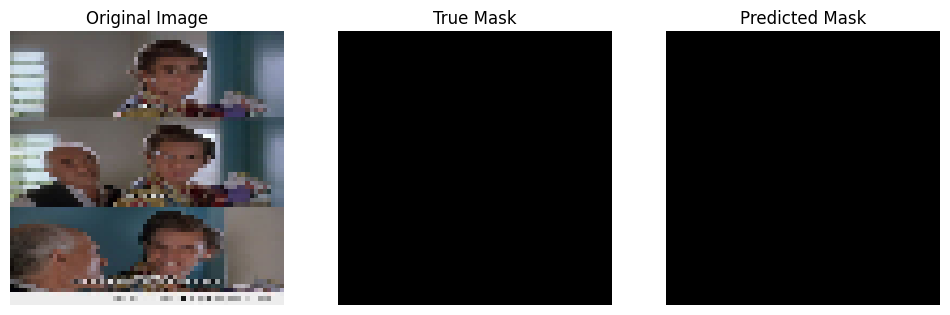

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Index of the test image to visualize
image_index = 3

# Get the test image and corresponding true mask
test_image = X_test[image_index]
true_mask = Y_test[image_index]
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Set up the plot
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis('off')

# True Mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("True Mask")
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Show the plot
plt.show()


# Part B - Q1 - Read/import images from folder ‘training_images’.

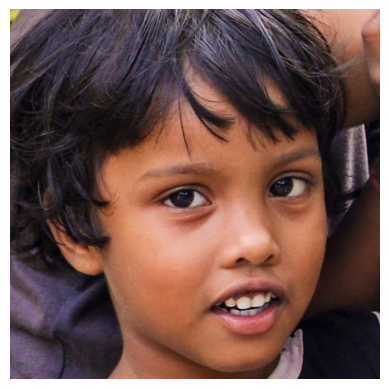

In [28]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the folder containing images
folder_path = r'training_images-20211126T092819Z-001\training_images'

# List to store images
images = []

# Load images
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image_rgb)
            #print(f'Loaded {filename}')

# Display the first image
if images:
    plt.imshow(images[0])
    plt.axis('off') 
    plt.show()
else:
    print("No images found.")


# Part B - Q2 - Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.
# Part B - Q3 - From the same loop above, extract metadata of the faces and write into a DataFrame
# Part B - Q4 - Save the output Dataframe in .csv format. 

In [29]:
import cv2
import os
import pandas as pd

# Path to the folder containing images
folder_path = r'training_images-20211126T092819Z-001\training_images'

# Load the Haar Cascade for face detection
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

# List to hold face metadata
face_metadata = []

# Function to detect faces in an image and return their metadata
def detect_faces(image, filename):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    total_faces = len(faces)
    metadata = []
    for (x, y, w, h) in faces:
        # Append metadata to the list
        metadata.append({
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'Total_faces': total_faces,
            'Image_name': filename
        })
    return metadata

# Iterate through all images in the folder and detect faces
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        
        if image is not None:
            # Detect faces and get metadata
            metadata = detect_faces(image, filename)
            face_metadata.extend(metadata)
        else:
            print(f'Error loading {filename}')

# Convert metadata list to a DataFrame
df = pd.DataFrame(face_metadata, columns=['x', 'y', 'w', 'h', 'Total_faces', 'Image_name'])

# Save DataFrame to a CSV file
csv_file_path = 'face_metadata.csv'
df.to_csv(csv_file_path, index=False)

print(f'Metadata saved to {csv_file_path}')


Metadata saved to face_metadata.csv


# Part C - Q1 - Unzip, read and Load data(‘PINS.zip’) into session.

In [30]:
import os
import zipfile

zip_file_path = 'PINS.zip'
extract_folder = 'extracted_images'
excluded_folders = ['PINS/pins_Natalie Portman', 'PINS/pins_kiernan shipka']

def safe_extract_zip(zip_file_path, extract_folder, excluded_folders):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            # Skip special macOS files and directories
            if file_info.filename.startswith('__MACOSX') or file_info.filename.startswith('._'):
                continue

            # Skip files in the excluded folders
            if any(file_info.filename.startswith(excluded_folder) for excluded_folder in excluded_folders):
                continue

            # Construct the path for extraction
            extracted_file_path = os.path.join(extract_folder, file_info.filename)

            # Ensure the directory exists
            directory = os.path.dirname(extracted_file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Extract the file if it's not a directory
            if not file_info.is_dir():
                try:
                    with zip_ref.open(file_info.filename) as source, open(extracted_file_path, 'wb') as target:
                        target.write(source.read())
                except FileNotFoundError as e:
                    print(f"FileNotFoundError: {e}")

safe_extract_zip(zip_file_path, extract_folder, excluded_folders)


# Part C - Q2 - Write function to create metadata of the image.
# Part C - Q3 - Write a loop to iterate through each and every image and create metadata for all the images.

In [59]:
import cv2
import numpy as np
import os
from PIL import Image


class IdentityMetadata:
    def __init__(self, base, name, file, format, mode, size):
        self.base = base
        self.name = name
        self.file = file
        self.format = format
        self.mode = mode
        self.size = size

    def __repr__(self):
        return (f"{self.image_path()} (Format: {self.format}, Mode: {self.mode}, "
                f"Size: {self.size})")

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def read_and_convert_image(image_path):
    """
    Read an image using OpenCV and convert it from BGR to RGB.

    :param image_path: Path to the image file.
    :return: The image in RGB format.
    """
    bgr_image = cv2.imread(image_path)
    if bgr_image is None:
        raise FileNotFoundError(f"Image file not found: {image_path}")
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

def load_metadata(path):
    metadata = []
    for identity in os.listdir(path):
        identity_path = os.path.join(path, identity)
        if os.path.isdir(identity_path):
            for file_name in os.listdir(identity_path):
                ext = os.path.splitext(file_name)[1].lower()
                if ext in ['.jpg', '.jpeg']:
                    image_path = os.path.join(identity_path, file_name)
                    try:
                        with Image.open(image_path) as img:
                            format = img.format
                            mode = img.mode
                            size = img.size
                            metadata.append(IdentityMetadata(path, identity, file_name, format, mode, size))
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
    return np.array(metadata)

# Define the folder containing the extracted images
extract_folder = 'extracted_images/PINS'

# Call load_metadata to read the images and assign metadata to a variable
metadata = load_metadata(extract_folder)


def load_image_data(image_path, threshold=10):
    """
    Load an image using OpenCV, convert it from BGR to RGB, and display its pixel array.

    :param image_path: Path to the image file.
    :param threshold: The threshold for displaying array data. 
    :return: None
    """
    # Read the image in BGR format
    bgr_image = cv2.imread(image_path)
    if bgr_image is None:
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Convert BGR image to RGB
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Display the image array
    print("Image array data:")
    print(np.array2string(rgb_image, threshold=threshold))  # Adjust the threshold for more or less data


if len(metadata) > 0:
    # Load and display the image array of the first image
    load_image_data(metadata[0].image_path()) 
else:
    print("No images found in metadata.")

load_image_data(metadata[0].image_path())

Image array data:
[[[233 188 165]
  [231 186 163]
  [220 178 156]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 [[232 187 164]
  [233 188 165]
  [220 178 156]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 [[230 186 161]
  [228 184 159]
  [206 164 140]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 ...

 [[198 118  91]
  [197 120  94]
  [195 119  95]
  ...
  [ 78  66  76]
  [ 78  66  76]
  [ 78  66  76]]

 [[200 120  93]
  [200 120  93]
  [198 121  95]
  ...
  [ 78  66  76]
  [ 78  66  76]
  [ 78  66  76]]

 [[201 121  94]
  [201 121  94]
  [199 122  96]
  ...
  [ 78  66  76]
  [ 78  66  76]
  [ 78  66  76]]]
Image array data:
[[[233 188 165]
  [231 186 163]
  [220 178 156]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 [[232 187 164]
  [233 188 165]
  [220 178 156]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 [[230 186 161]
  [228 184 159]
  [206 164 140]
  ...
  [106  63  72]
  [106  63  72]
  [106  63  72]]

 ...

 [[198 118  91]


# Part C - Q4 - Generate Embeddings vectors on the each face in the dataset.

In [55]:
import cv2
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

# Define the VGG face model
def vgg_face():
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))  
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

# Initialize the VGG face model
model = vgg_face()

# Create a model for obtaining embeddings
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

def load_image(image_path):
    # Read the image from the file path
    img = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if img is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    
    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

img_path = metadata[0].image_path()

# Load and preprocess the image
img = load_image(img_path)
print(f"Image shape before resizing: {img.shape}")

# Normalize pixel values from [0-255] to [0-1]
img = (img / 255.).astype(np.float32)

# Resize image to match the input shape required by the model
img = cv2.resize(img, dsize=(224, 224))
print(f"Image shape after resizing: {img.shape}")

# Obtain embedding vector for an image
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(f"Embedding vector shape: {embedding_vector.shape}")


Image shape before resizing: (301, 299, 3)
Image shape after resizing: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Embedding vector shape: (2622,)


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Model
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define the embedding dimension
embedding_dim = 2622
batch_size = 32  
num_threads = 8  

# Initialize a dictionary to store embeddings for all images
embeddings_dict = {}

def load_image(image_path):
    """Function to load and preprocess the image"""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match input shape of the model
    img = preprocess_input(img)  # Use preprocessing function suitable for the model
    return img

def process_image(image_path):
    """Function to process a single image"""
    img = load_image(image_path)
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    return embedding_vector

def batch_process_images(image_paths):
    """Process a list of image paths in batches"""
    embeddings = []
    for batch_start in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[batch_start:batch_start + batch_size]
        batch_images = [load_image(path) for path in batch_paths]
        batch_embeddings = vgg_face_descriptor.predict(np.array(batch_images))
        embeddings.extend(batch_embeddings)
    return embeddings

def process_images_in_parallel(metadata):
    """Process all images in parallel using ThreadPoolExecutor"""
    image_paths = [meta.image_path() for meta in metadata]
    
    # Use ThreadPoolExecutor to parallelize image processing
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_index = {executor.submit(process_image, path): idx for idx, path in enumerate(image_paths)}
        
        for future in as_completed(future_to_index):
            idx = future_to_index[future]
            try:
                embedding = future.result()
                embeddings_dict[idx] = embedding
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                embeddings_dict[idx] = np.zeros(embedding_dim)

# Load the model
model = vgg_face_descriptor  

# Process images in parallel
process_images_in_parallel(metadata)

print("Embeddings have been computed for all images.")
